In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import multibind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '/mnt/c/Users/ignacio.ibarra/Dropbox/annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

/home/rio/miniconda3/envs/multibind/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [3]:
data = bd.bindome.datasets.SELEX.get_data()
# data[data['cycle'] == 'AF']
data

,filename,library,batch,cycle,tf.name,accession
0,ZeroCycle_ES0_TACTAT20NATC_0.txt.gz,TACTAT20NATC,ES0,0,ZEROCYCLE,PRJEB14744
1,ZeroCycle_ES0_TCTCTT20NGA_0.txt.gz,TCTCTT20NGA,ES0,0,ZEROCYCLE,PRJEB14744
2,ZeroCycle_ES0_TGTAAA20NGA_0.txt.gz,TGTAAA20NGA,ES0,0,ZEROCYCLE,PRJEB14744
3,ZeroCycle_ES0_TGTACC30NCAG_0.txt.gz,TGTACC30NCAG,ES0,0,ZEROCYCLE,PRJEB14744
4,ZeroCycle_ES0_TGTGTC20NGA_0.txt.gz,TGTGTC20NGA,ES0,0,ZEROCYCLE,PRJEB14744
...,...,...,...,...,...,...
86,FOXA1_FL_2_KX_TCCCAT40NTGT.fastq.gz,TCCCAT40NTGT,FL,2,FOXA1,PRJEB9797
87,FOXA1_FL_3_KX_TAGCGT40NTCA.fastq.gz,TAGCGT40NTCA,FL,3,FOXA1,PRJEB9797
88,FOXA1_FL_3_KX_TCCCAT40NTGT.fastq.gz,TCCCAT40NTGT,FL,3,FOXA1,PRJEB9797
89,FOXA1_FL_4_KX_TAGCGT40NTCA.fastq.gz,TAGCGT40NTCA,FL,4,FOXA1,PRJEB9797


In [17]:

model_by_k = {}
for tf in set(data['tf.name']):
    if 'ZERO' in tf:
        continue
    print(tf)
    
    for library, grp in data.groupby('library'):
        
        data_sel_tf = grp[grp['tf.name'] == tf]
        if data_sel_tf.shape[0] == 0:
            continue

        reads_tf = mb.bindome.datasets.SELEX.load_read_counts(tf, data=data_sel_tf)
        data_sel_zero = grp[(grp['cycle'] == 0) & grp['library'].isin(set(grp[grp['tf.name'] == tf]['library']))]
        reads_zero = mb.bindome.datasets.SELEX.load_read_counts(tf, data=data_sel_zero)
        
        print(reads_tf.keys())
        print(reads_zero.keys())
        
        for k_tf in reads_tf:
            for k_r0 in reads_zero:
                print(k_r0, k_tf)
                
                k_model = tf + ':' + k_r0 + ':' + k_tf

                n_rounds = 1

                next_data = reads_zero[k_r0].merge(reads_tf[k_tf], on='seq', how='outer').fillna(0) # .astype(int)
                new_cols = ['seq', k_r0, k_tf]
                next_data.columns = ['seq', k_r0, k_tf]
                for i, k in enumerate([k_r0, k_tf]):
                    next_data[k] = next_data[k].astype(int)
                    next_data[i] = next_data[k].astype(int)


                next_data = next_data.head(1000)
                print(next_data.shape)
                
                print(next_data.head())
                
                next_data = mb.tl.calculate_enrichment(next_data, cols=next_data.columns[1:])
                
                # assign batch and data type
                next_data['batch'] = 1
                next_data['is_count_data'] = 1

                dataset = mb.datasets.SelexDataset(next_data) # n_rounds=n_rounds)
                train = tdata.DataLoader(dataset=dataset, batch_size=256, shuffle=True)
                train_test = tdata.DataLoader(dataset=dataset, batch_size=1, shuffle=False)                
                ### here add the steps to train model
                #### 
                # l2 = []
                # optimiser = topti.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
                # # optimiser = topti.LBFGS(model.parameters())
                criterion = mb.tl.PoissonLoss()
                
                # l2 += 
                model = mb.models.DinucSelex().to(device)
                optimiser = topti.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
                mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=10, log_each=1)
                
                # probably here load the state of the best epoch and save 
                
                # store model parameters and fit for later visualization
                model_by_k[k_model] = model
                
                assert False
                
                # stop (debugging)
                

FOXA1
# uniq reads/total counts 191580/195771
# uniq reads/total counts 160291/165113
# uniq reads/total counts 149248/253102
# uniq reads/total counts 86056/305659
# uniq reads/total counts 147714/148050
dict_keys(['FOXA1_FL_1_KX_TAGCGT40NTCA', 'FOXA1_FL_2_KX_TAGCGT40NTCA', 'FOXA1_FL_3_KX_TAGCGT40NTCA', 'FOXA1_FL_4_KX_TAGCGT40NTCA'])
dict_keys(['ZeroCycle_TAGCGT40NTCA_0_0'])
ZeroCycle_TAGCGT40NTCA_0_0 FOXA1_FL_1_KX_TAGCGT40NTCA
(1000, 5)
                                        seq  ZeroCycle_TAGCGT40NTCA_0_0  \
0  TGCAGTCTATATAGTTAATATAGGCCCCCCTGTGACTAGC                           3   
1  TCCGTTGGCACAGGACAAATAGGCACTTACGTTCAACGCA                           2   
2  TCAACCCAGCAAGGCGATCCCCAGACTAACAAACCCGCAA                           2   
3  ATGCCCTCTTTCCCCTCACTCTCTGACATTCACACGAGCG                           2   
4  TAACTCTAAAGGCCTAGGAAAGATTCTGTGACGGCTACAA                           2   

   FOXA1_FL_1_KX_TAGCGT40NTCA  0  1  
0                           0  3  0  
1                           0 

AssertionError: 

FOXA1:ZeroCycle_TAGCGT40NTCA_0_0:FOXA1_FL_1_KX_TAGCGT40NTCA
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


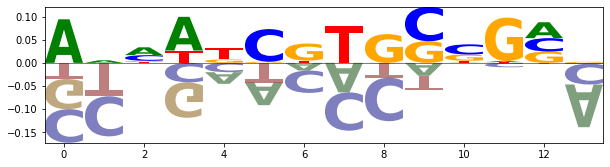

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


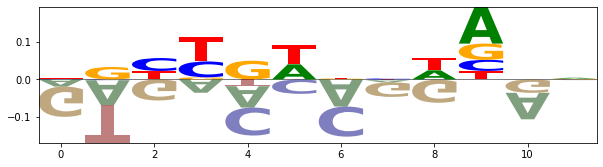

In [38]:
for k in model_by_k:
    print(k)
    model = model_by_k[k] 
    mb.pl.conv_mono(model)
    print('')